In [1]:
import numpy as np
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

N = 50000

unlearn = np.load("feature/unlearn.npz")
backdoor = np.load("feature/backdoor.npz")
poison_id = np.load("feature/poison_id.npy")

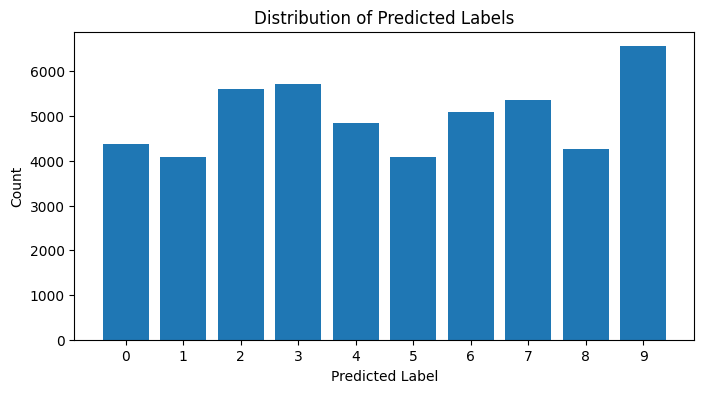

In [2]:
labels = unlearn["labels"]
logits = unlearn["logits"]
preds = np.argmax(logits, axis=1)
correct_mask = preds == labels

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(preds, bins=np.arange(preds.min(), preds.max()+2)-0.5, rwidth=0.8)
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.arange(preds.min(), preds.max()+1))
plt.show()


In [3]:

poison_mask = np.zeros(N, dtype=bool)
poison_mask[poison_id] = True
clean_mask = ~poison_mask

print(f"correct_num: {np.sum(correct_mask)}")
print(f"poison_correct_num: {np.sum(poison_mask & correct_mask)}")

correct_num: 18948
poison_correct_num: 480


In [4]:
unlearn_features = unlearn["features"]
backdoor_features = backdoor["features"]

unlearn_logits = unlearn["logits"]
backdoor_logits = backdoor["logits"]

In [5]:
l2_2 = norm(unlearn_features, axis=1)
l2_diff = norm(backdoor_features - unlearn_features, axis=1)

cos_sim = cosine_similarity(backdoor_features, unlearn_features).diagonal()

(18948,)


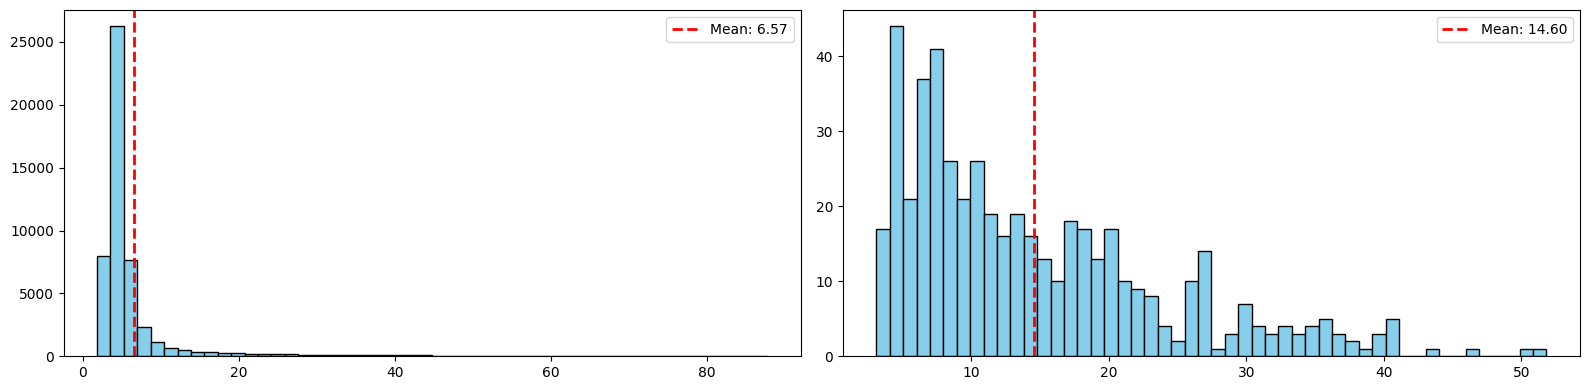

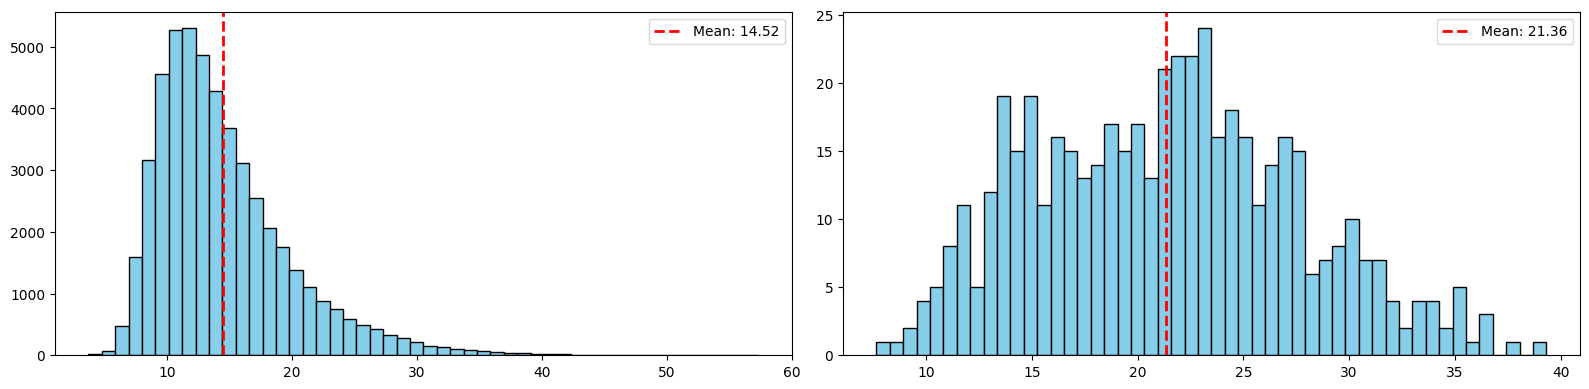

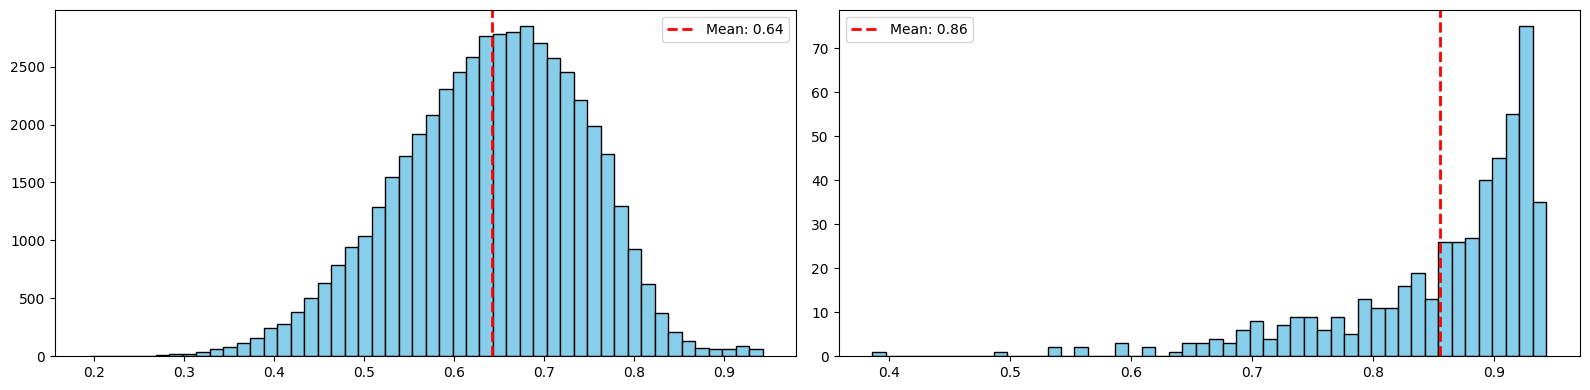

In [6]:
def l2_diff_pic(l2_diff, poison_mask):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    axes[0].hist(l2_diff, bins=50, color="skyblue", edgecolor="black")
    axes[0].axvline(
        l2_diff.mean(),
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Mean: {l2_diff.mean():.2f}",
    )
    axes[0].legend()

    axes[1].hist(l2_diff[poison_mask], bins=50, color="skyblue", edgecolor="black")
    axes[1].axvline(
        l2_diff[poison_mask].mean(),
        color='red',
        linestyle='dashed',
        linewidth=2,
        label=f'Mean: {l2_diff[poison_mask].mean():.2f}'
    )
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
print(l2_2[correct_mask].shape)

l2_diff_pic(l2_2, poison_mask)
l2_diff_pic(l2_diff, poison_mask)
l2_diff_pic(cos_sim, poison_mask)

In [7]:
# 对全部样本按l2_2从大到小排序
all_sorted_indices = np.argsort(-l2_2)
# 对预测正确样本按l2_2从大到小排序
correct_l2_2 = l2_2[correct_mask]
correct_sorted_indices_l2 = np.argsort(-correct_l2_2)
correct_indices_l2 = np.where(correct_mask)[0]
sorted_correct_indices_l2 = correct_indices_l2[correct_sorted_indices_l2]

# 对每个后门样本，打印其id、l2_2值、全部样本排名、预测正确样本排名，按all_rank排序
poison_ranks = []
for pid in poison_id:
    l2_value = l2_2[pid]
    all_rank = np.where(all_sorted_indices == pid)[0][0] + 1
    if correct_mask[pid]:
        correct_rank = np.where(sorted_correct_indices_l2 == pid)[0][0] + 1
    else:
        correct_rank = None
    poison_ranks.append((all_rank, pid, l2_value, correct_rank))

# 按all_rank排序并打印
for all_rank, pid, l2_value, correct_rank in sorted(poison_ranks):
    print(
        f"id: {pid}, l2_2: {l2_value:.6f}, all_rank: {all_rank}, correct_rank: {correct_rank}"
    )

id: 41034, l2_2: 51.819111, all_rank: 262, correct_rank: 60
id: 37055, l2_2: 50.024193, all_rank: 306, correct_rank: 72
id: 25257, l2_2: 46.022469, all_rank: 434, correct_rank: 97
id: 8199, l2_2: 43.296665, all_rank: 541, correct_rank: 121
id: 10555, l2_2: 40.870922, all_rank: 653, correct_rank: 146
id: 33361, l2_2: 40.847034, all_rank: 655, correct_rank: 147
id: 35566, l2_2: 40.831131, all_rank: 656, correct_rank: 148
id: 47777, l2_2: 40.788609, all_rank: 658, correct_rank: 149
id: 22533, l2_2: 40.221386, all_rank: 692, correct_rank: 159
id: 46655, l2_2: 39.911850, all_rank: 707, correct_rank: 160
id: 41521, l2_2: 39.796265, all_rank: 717, correct_rank: 161
id: 35168, l2_2: 39.515728, all_rank: 734, correct_rank: 164
id: 349, l2_2: 38.655514, all_rank: 774, correct_rank: 173
id: 46938, l2_2: 37.715046, all_rank: 834, correct_rank: 187
id: 27748, l2_2: 37.676735, all_rank: 836, correct_rank: 188
id: 24823, l2_2: 36.847633, all_rank: 881, correct_rank: 196
id: 23296, l2_2: 36.520531, al

In [8]:
sorted_indices = np.argsort(-cos_sim)

# 找出排名中的后门样本（即排名列表中属于后门的索引）
ranked_poison_in_correct = [idx for idx in sorted_indices if idx in poison_id]

for rank, idx in enumerate(ranked_poison_in_correct, 1):
    # 打印后门样本在全部预测正确样本中的排名
    # 全部样本中的排名（按cos_sim从高到低）
    all_rank = (sorted_indices == idx).nonzero()[0][0] + 1
    print(f"id: {idx}, cos_sim: {cos_sim[idx]:.6f}, rank: {all_rank}")



id: 35500, cos_sim: 0.942948, rank: 1
id: 14266, cos_sim: 0.942894, rank: 2
id: 37862, cos_sim: 0.940998, rank: 3
id: 19582, cos_sim: 0.940285, rank: 4
id: 14229, cos_sim: 0.939860, rank: 5
id: 29189, cos_sim: 0.939574, rank: 6
id: 41034, cos_sim: 0.939229, rank: 7
id: 8588, cos_sim: 0.938380, rank: 8
id: 4355, cos_sim: 0.937872, rank: 9
id: 41521, cos_sim: 0.937810, rank: 10
id: 14063, cos_sim: 0.937695, rank: 11
id: 37370, cos_sim: 0.937666, rank: 12
id: 42557, cos_sim: 0.937633, rank: 13
id: 6491, cos_sim: 0.937139, rank: 14
id: 46680, cos_sim: 0.937034, rank: 15
id: 47145, cos_sim: 0.936831, rank: 16
id: 23200, cos_sim: 0.936665, rank: 17
id: 28233, cos_sim: 0.936474, rank: 18
id: 44563, cos_sim: 0.936169, rank: 19
id: 9371, cos_sim: 0.936006, rank: 20
id: 31514, cos_sim: 0.935965, rank: 21
id: 13251, cos_sim: 0.935963, rank: 22
id: 564, cos_sim: 0.935501, rank: 23
id: 30248, cos_sim: 0.934982, rank: 24
id: 15512, cos_sim: 0.934815, rank: 25
id: 27895, cos_sim: 0.934359, rank: 26
i

In [10]:
a = 0.005
suspect_ids = sorted_indices[:int(N * 0.005)]
print("suspect_ids:\n", suspect_ids)
# 计算后门样本的数量和占比
num_poison_in_top250 = np.sum(poison_mask[suspect_ids])
ratio_poison_in_top250 = num_poison_in_top250 / len(suspect_ids)
print(f"后门样本数量: {num_poison_in_top250}, 占比: {ratio_poison_in_top250:.4f}")

np.save("suspect_ids", suspect_ids)

suspect_ids:
 [35500 14266 37862 19582 14229 29189 41034  8588  4355 41521 14063 37370
 42557  6491 46680 47145 23200 28233 44563  9371 31514 13251   564 30248
 15512 27895 37055 49786 17614 10555  5634 24414 34666 26415 35168 24343
 31577  7877   365 17832 43478 22244   349 24823 37639 36102 32330 39595
 35488 43622 24966 46097 19267  7592 23348 22795  6982 17590 32137 42712
  5774 45985   124 30157 33263  1776 46655 23336 49162 22551 47777 15122
 25257 11253  8223 45768 28903 43502 18612 15387 37375  8534 45272    86
 13573  3516 33361  6781 49579  4830 49877  1074 36158  8199 46459  4634
 39459   362 38245 12686 48170 32468 16894  6498 46938 24636 42323 18525
 19348 16691 27409 23296 28291 34744  5001 13286  1065 30706  4281 42780
  7945 43032 42187 13582 48249 38753  2981 36558 49903 14494 40398 42596
 16874  9546 14952 23202 32930 37760 29333 14873 24782  7729 27748  5619
 25406 43962 15434 47484   179 32680  5298 42581  7075 28447 48748 12322
  8214 16643  5857  4690 25665 11684 